In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

In [2]:
def scatter_and_satfrac(params, logms_bin, logmh_bin, cfg, um_mock):
    """
    Measure the scatter of stellar and halo mass, also the 
    satellite fraction.
    """
    logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
        um_data['um_mock'], params, min_logms=10.5,
        logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
        pivot=cfg['um']['pivot_logmh'])
    
    # Mask for central galaxies
    um_mock_use = um_mock[mask_use]
    
    mask_cen = um_mock_use['upid'] == -1
    
    # Stellar and halo mass of central galaxies
    logms_cen = logms_tot[mask_cen]
    logmh_cen = um_mock_use['logmh_vir'][mask_cen]

    # Stellar and halo mass of all galaxies, including satellites
    logms_all = logms_tot
    logmh_all = um_mock_use['logmh_vir']

    # Group the central galaxies into stellar and halo mass bins
    idx_logms_cen = np.digitize(logms_cen, logms_bin)
    idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)

    # Group all galaxies into stellar and halo mass bins
    idx_logms_all = np.digitize(logms_all, logms_bin)
    idx_logmh_all = np.digitize(logmh_all, logmh_bin)

    # Mean stellar and halo mass in each bin
    logms_mean = [np.nanmean(logms_all[idx_logms_all == k])
                  for k in range(len(logms_bin))]
    logmh_mean = [np.nanmean(logmh_all[idx_logmh_all == k])
                  for k in range(len(logmh_bin))]
    
    # Scatter of halo mass in each stellar mass bin for both central and all galaxies
    sigmh_cen = [np.nanstd(logmh_cen[idx_logms_cen == k])
                 for k in range(len(logms_bin))]
    sigmh_all = [np.nanstd(logmh_all[idx_logms_all == k])
                 for k in range(len(logms_bin))]

    # Scatter of stellar mass in each halo mass bin for both central and all galaxies
    sigms_cen = [np.nanstd(logms_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
    sigms_all = [np.nanstd(logms_all[idx_logmh_all == k])
                 for k in range(len(logmh_bin))]
    
    # Fraction of satellite in each stellar mass bin
    frac_sat = np.array(
        [((len(um_mock_use[idx_logms_all == k]) - np.sum(mask_cen[idx_logms_all == k])) * 1.0 /
          (len(um_mock_use[idx_logms_all == k]))) for k in range(len(logms_bin))]) * 100.0
    
    return sigmh_cen, sigmh_all, sigms_cen, sigms_all, frac_sat

## Scatter along the aperture mass plane

In [3]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load in the final sampling results
(mod_result_samples,
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

_, n_step, n_dim = mod_result_chains.shape

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

print("\n", mod_result_best)

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for  9000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

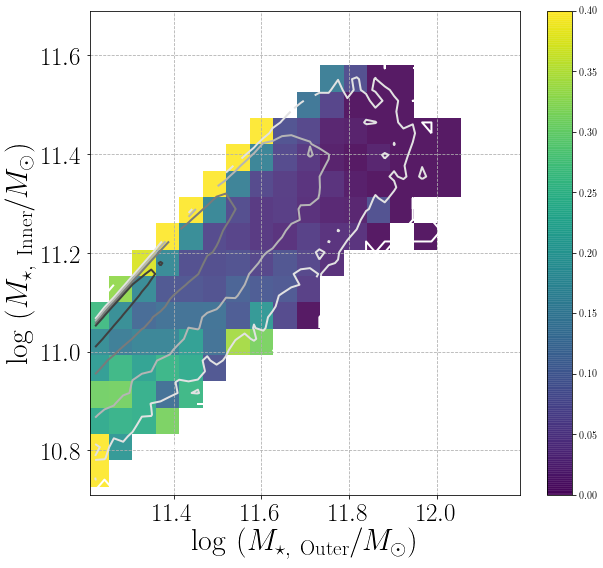

In [7]:
cen_mask = um_data['um_mock'][mask_use]['upid'] == -1

x_test = logms_tot 
y_test = logms_inn 
x_range = [11.2, 12.8]
y_range = [10.3, 11.9]
bins = [30, 30]

mask_test = ((x_test > x_range[0]) & (x_test < x_range[1]) & 
             (y_test > y_range[0]) & (y_test < y_range[1])) 
    
# Assign each test data point to the same 2-D bins
cen_counts, x_edges_test, y_edges_test = binned_statistic_2d(
    x_test[cen_mask], y_test[cen_mask], x_test[cen_mask], 'count', 
    bins=bins, range=[x_range, y_range])

sat_counts, x_edges_test, y_edges_test = binned_statistic_2d(
    x_test[~cen_mask], y_test[~cen_mask], x_test[~cen_mask], 'count', 
    bins=bins, range=[x_range, y_range])

cen_counts = np.where(cen_counts <= 10, 0, cen_counts)
sat_counts = np.where(cen_counts <= 10, 0, sat_counts)

sat_frac_2d = sat_counts / cen_counts

fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.16, right=0.99,
                    bottom=0.15, top=0.99,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

im = ax1.imshow(sat_frac_2d.T, origin='lower',
                extent=[x_edges_test[0], x_edges_test[-1], y_edges_test[0], y_edges_test[-1]],
                aspect='auto', interpolation='nearest', alpha=0.9,
                cmap=plt.get_cmap('viridis'), vmin=0.0, vmax=0.4)

counts, xbins, ybins = np.histogram2d(x_test[mask_test], y_test[mask_test], bins=[50, 50])
ax1.contour(xbins[1:], ybins[1:], np.log10(counts.T), linewidths=2, levels=4, cmap='Greys')

ax1.grid(linestyle='--')

plt.colorbar(im)

_ = ax1.set_xlabel(r'$\log\ (M_{\star,\ \mathrm{Outer}} / M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log\ (M_{\star,\ \mathrm{Inner}} / M_{\odot})$', fontsize=30)

_ = ax1.set_xlim(11.21, 12.19)
_ = ax1.set_ylim(10.71, 11.69)

### Visualize the best-fit relation between halo mass and scatter of TSHMR

Text(0, 0.5, '$\\sigma_{\\log M_{\\star, \\rm Halo}}$')

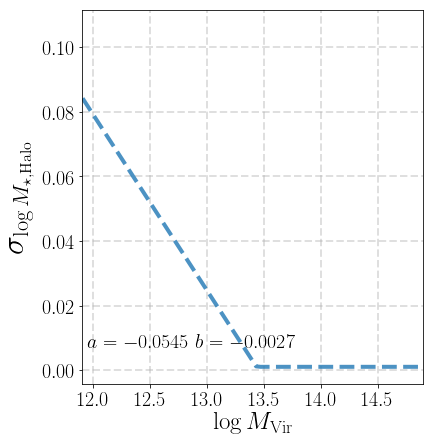

In [4]:
sigms_a, sigms_b = mod_result_best[2], mod_result_best[3]
#scatter_a, scatter_b = 0.035, 0.012
min_scatter = 0.001

fig_1 = plt.figure(figsize=(6, 6))
fig_1.subplots_adjust(left=0.205, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

logmh_arr = np.linspace(11.5, 15.4, 100)
sig_ms = sigms_a * (np.asarray(logmh_arr) - 13.5) + sigms_b
sig_ms = np.where(sig_ms <= min_scatter, min_scatter, sig_ms)

ax1.plot(logmh_arr, sig_ms, linewidth=4.0, linestyle='--', alpha=0.8)

_ = ax1.text(
    0.32, 0.09, r"$a=%7.4f\ b=%7.4f$" % (sigms_a, sigms_b),
    verticalalignment='bottom', horizontalalignment='center', fontsize=20,
    transform=ax1.transAxes)

ax1.set_xlim(11.9, 14.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=25)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Halo}}$',
               fontsize=32)

### Scatter across the aperture mass plane

/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


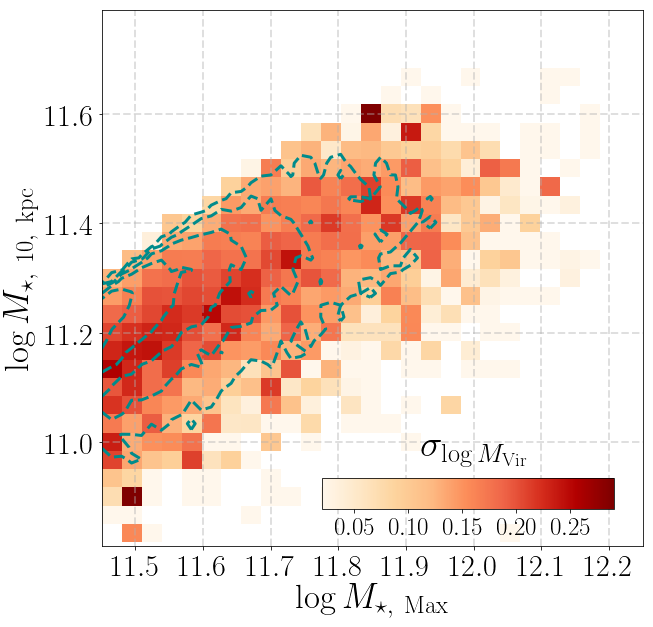

In [9]:
# Select galaxies to show
mask_mod = ((logms_tot >= 11.45) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70) & (um_mock_use['upid'] == -1))

fig_2 = plt.figure(figsize=(9.0, 8.5))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# Color density plot that indicates the change of Mvir
x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanstd, bins=(25, 26))

HM = ax1.imshow(z_stats.T, origin='lower', cmap='OrRd',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=0.02, vmax=0.29, aspect='auto', interpolation='nearest')

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, 'count', bins=(50, 40))

CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(z_stats.T, 0.3),
                 4, linewidths=3, linestyles='dashed',
                 colors=['darkcyan'],
                 levels=[5, 20, 50, 100, 200],
                 extend='neither')

# Colorbar
cax = fig_2.add_axes([0.50, 0.18, 0.45, 0.05])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")

ax1.text(0.59, 0.15, r'$\sigma_{\log M_{\rm Vir}}$', transform=ax1.transAxes, size=38)

for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.25)
_ = ax1.set_ylim(10.81, 11.79)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

## Trends for scatters of stellar and halo mass

In [13]:
# Use the walkers from the last 20 steps of the chains to test the uncertainties of halo mass scatter
last_steps = mod_result_chains[:, -30:, :].reshape((-1, 7))

# Define a series of stellar and halo mass bins
logms_bin = np.linspace(11.4, 12.4, 9)
logmh_bin = np.linspace(13.2, 15.4, 8)

# Measure the scatter of halo mass, stellar mass and satellite fractions by sampling the posterior 
# distributions
sigmh_cen_list, sigmh_all_list, sigms_cen_list, sigms_all_list, frac_sat_list = zip(
    *[scatter_and_satfrac(params, logms_bin, logmh_bin, cfg, um_data['um_mock']) 
      for params in last_steps])

sigmh_cen_arr = np.asarray(list(sigmh_cen_list))
sigmh_all_arr = np.asarray(list(sigmh_all_list))
sigms_cen_arr = np.asarray(list(sigms_cen_list))
sigms_all_arr = np.asarray(list(sigms_all_list))
frac_sat_arr = np.asarray(list(frac_sat_list))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


In [14]:
# Mask for central galaxies
mask_cen = um_mock_use['upid'] == -1

# Stellar and halo mass for central galaxies
logms_cen = logms_tot[mask_cen]
logmh_cen = um_mock_use['logmh_vir'][mask_cen]

# Group central galaxies into those bins
idx_logms_cen = np.digitize(logms_cen, logms_bin)
idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)

# Mean stellar and halo mass in each bin
logms_mean = [np.nanmean(logms_cen[idx_logms_cen == k])
              for k in range(len(logms_bin))]

logmh_mean = [np.nanmean(logmh_cen[idx_logmh_cen == k])
              for k in range(len(logmh_bin))]

sigmh_cen = [np.nanstd(logmh_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]

sigms_cen = [np.nanstd(logms_cen[idx_logmh_cen == k])
             for k in range(len(logmh_bin))]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


### Scatter of stellar mass at fixed halo mass

Text(0, 0.5, '$\\sigma_{\\log M_{\\star, \\rm Cen}}$')

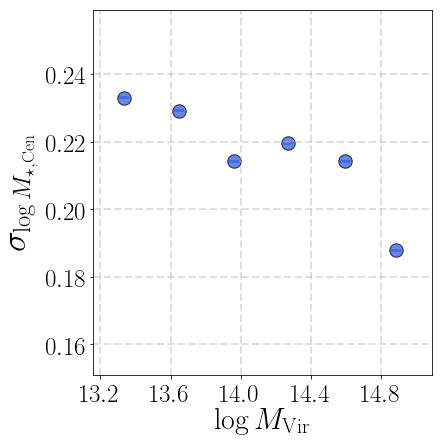

In [15]:
fig_3 = plt.figure(figsize=(6, 6))
fig_3.subplots_adjust(left=0.21, right=0.995, bottom=0.15, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

ax1.xaxis.set_ticks([13.2, 13.6, 14.0, 14.4, 14.8])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

sigms_cen_avg = np.mean(sigms_cen_arr, axis=0)

ax1.scatter(logmh_mean, sigms_cen_avg, 
            s=180, alpha=0.8, edgecolor='k', facecolor='royalblue')

yerr = np.stack([np.nanmax(sigms_cen_arr, axis=0) - sigms_cen_avg,
                 sigms_cen_avg - np.nanmin(sigms_cen_arr, axis=0)])

ax1.errorbar(logmh_mean, sigms_cen_avg, 
             yerr=yerr, fmt='o', ecolor='royalblue', elinewidth=2.5, 
             capsize=5, capthick=2.0, color='royalblue', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.set_xlim(13.16, 15.09)
ax1.set_ylim(0.151, 0.259)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Cen}}$', fontsize=35)

### Scatter of halo mass at fixed stellar mass

In [16]:
# Select galaxies to show
mask_mod = ((logms_tot >= 11.35) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70) & 
            (um_mock_use['upid'] == -1))

# Color density plot that indicates the change of Mvir
x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats_2, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanstd, bins=(15, 15))

x_cens = (x_edges[:-1] + x_edges[1:]) / 2.0
y_cens = (y_edges[:-1] + y_edges[1:]) / 2.0

x_cen_arr, y_cen_arr = np.meshgrid(x_cens, y_cens)

mask_use = (z_stats_2 >= 0.03)

logms_bin_2d = np.linspace(11.4, 12.4, 9)
idx_logms_2d = np.digitize(x_cen_arr[mask_use], logms_bin_2d)

logms_mean_2d = [np.nanmean(x_cen_arr[mask_use][idx_logms_2d == k])
                 for k in range(len(logms_bin_2d))]

sigmh_2d = [np.nanmean(z_stats_2[mask_use][idx_logms_2d == k])
            for k in range(len(logms_bin_2d))]

sigmh_err_2d = [np.nanstd(z_stats_2[mask_use][idx_logms_2d == k])
                for k in range(len(logms_bin_2d))]

/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered


Text(0, 0.5, '$\\sigma_{\\log M_{\\rm Vir}}$')

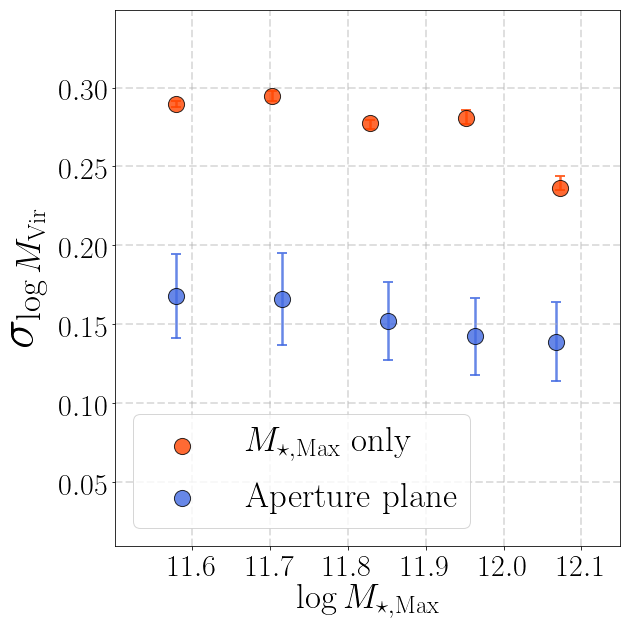

In [17]:
fig_3 = plt.figure(figsize=(8.5, 8.5))
fig_3.subplots_adjust(left=0.17, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
sigmh_cen_avg = np.mean(sigmh_cen_arr, axis=0)
ax1.scatter(logms_mean, sigmh_cen_avg, c='orangered', 
            s=260, alpha=0.8, edgecolor='k', zorder=2, label=r'$M_{\star, \rm Max}\ \mathrm{only}$')

ax1.scatter(logms_mean_2d, sigmh_2d, c='royalblue', 
            s=260, alpha=0.8, edgecolor='k', zorder=2, label=r'$\mathrm{Aperture\ plane}$')


yerr = np.stack([np.nanmax(sigmh_cen_arr, axis=0) - sigmh_cen_avg,
                 sigmh_cen_avg - np.nanmin(sigmh_cen_arr, axis=0)])

ax1.errorbar(logms_mean, sigmh_cen_avg, yerr=yerr, 
             fmt='o', ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.errorbar(logms_mean_2d, sigmh_2d, yerr=np.asarray(sigmh_err_2d) / 2.0, 
             fmt='o', ecolor='royalblue', elinewidth=2.5, capsize=5, capthick=2.0,
             color='royalblue', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)


ax1.set_xlim(11.501, 12.15)
ax1.set_ylim(0.01, 0.349)

ax1.legend(loc='lower left', fontsize=35)

ax1.set_xlabel(r'$\log M_{\star, \mathrm{Max}}$', fontsize=35)
ax1.set_ylabel(r'$\sigma_{\log M_{\rm Vir}}$', fontsize=50)

### Fraction of satellites and its relation with stellar mass

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered


Text(0, 0.5, '$\\mathrm{Fraction\\ of\\ Satellite}$')

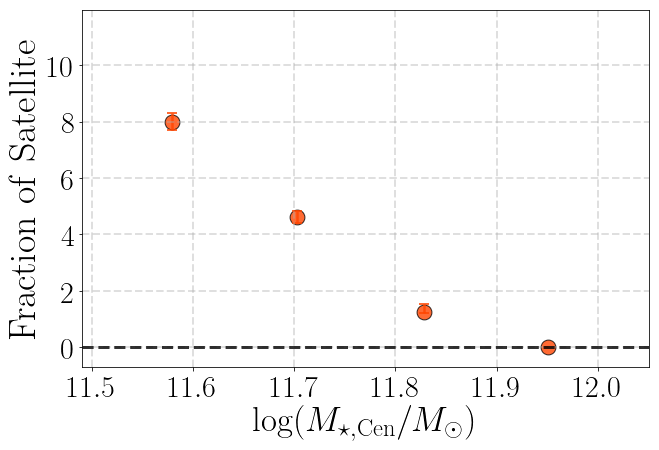

In [18]:
fig_4 = plt.figure(figsize=(9, 6))
fig_4.subplots_adjust(left=0.12, right=0.995, bottom=0.17, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_4.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

frac_sat_avg = np.mean(frac_sat_arr, axis=0)

ax1.scatter(logms_mean, frac_sat_avg, c='orangered', s=220, alpha=0.8, edgecolor='k')

yerr = np.stack([frac_sat_avg - np.nanmin(frac_sat_arr, axis=0),
                 np.nanmax(frac_sat_arr, axis=0) - frac_sat_avg])

ax1.errorbar(logms_mean, frac_sat_avg, yerr=yerr, 
             fmt='o', ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.set_xlim(11.49, 12.05)
ax1.set_ylim(-0.7, 11.95)

ax1.axhline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.set_xlabel(r'$\log (M_{\star, \mathrm{Cen}}/M_{\odot})$', fontsize=35)
ax1.set_ylabel(r'$\mathrm{Fraction\ of\ Satellite}$', fontsize=38)

## Save the figures

In [19]:
fig_2.savefig('fig/fig7_a.pdf', dpi=150)

fig_3.savefig('fig/fig7_b.pdf', dpi=150)

fig_1.savefig('fig/fig7_scatter_relation.png', dpi=120)

fig_4.savefig('fig/fig7_dependence.png', dpi=120)